In [42]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Add, Multiply, Lambda, Layer
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
im_width = 256
im_height = 256

image_filename_train = []

mask_files = glob(pathname='C:\\Users\\ashmi\\Desktop\\brain tumor detection\\kaggle_3m\\*\\*_mask*')
for i in mask_files:
    image_filename_train.append(i.replace('_mask',''))
print(image_filename_train[:10])
len(image_filename_train)

['C:\\Users\\ashmi\\Desktop\\brain tumor detection\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', 'C:\\Users\\ashmi\\Desktop\\brain tumor detection\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', 'C:\\Users\\ashmi\\Desktop\\brain tumor detection\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', 'C:\\Users\\ashmi\\Desktop\\brain tumor detection\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', 'C:\\Users\\ashmi\\Desktop\\brain tumor detection\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', 'C:\\Users\\ashmi\\Desktop\\brain tumor detection\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', 'C:\\Users\\ashmi\\Desktop\\brain tumor detection\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', 'C:\\Users\\ashmi\\Desktop\\brain tumor detection\\kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', 'C:\\Users\\ashmi\\Desktop\\brain tumor detection\\kaggle_3m\\TCGA_CS_4

3929

In [3]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize  = (12,12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.5)
    plt.show()

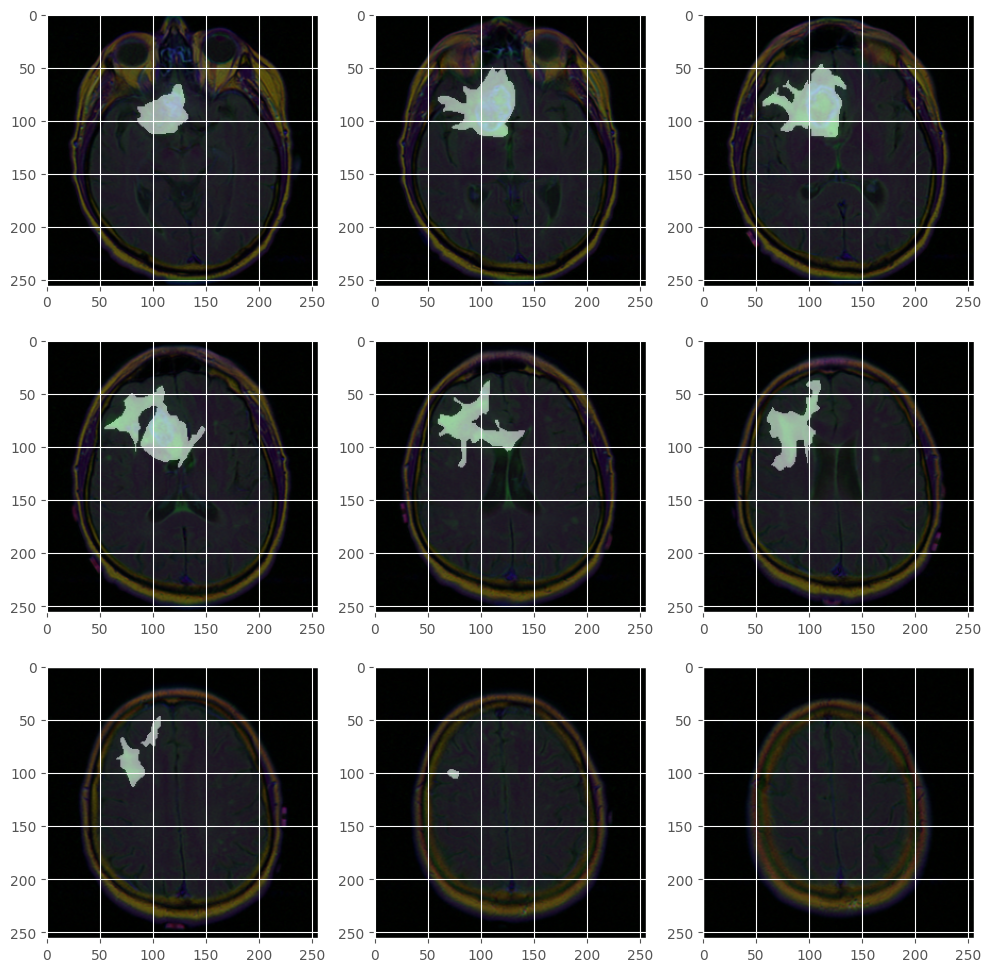

In [4]:
plot_from_img_path(3, 3, image_filename_train, mask_files)

In [23]:
df = pd.DataFrame(data = {'image_filename_train': image_filename_train, 'mask': mask_files})
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=5)
df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state=2)
print(f"Total dataset size: {len(df)}")
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Testing set size: {len(df_test)}")

Total dataset size: 3929
Training set size: 2514
Validation set size: 629
Testing set size: 786


In [25]:
train_images_with_tumor = []
train_images_without_tumor = []

# Iterate over each image and mask in df_test
for idx, row in df_train.iterrows():
    image_path = row['image_filename_train']
    mask_path = row['mask']
    
    # Load the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the mask has any white regions
    if np.any(mask > 0):  # There is a white region in the mask
        train_images_with_tumor.append(image_path)
    else:  # The mask is completely black
        train_images_without_tumor.append(image_path)

# Display the count of images in each category
print(f'Train Images with tumor: {len(train_images_with_tumor)}')
print(f'Train Images without tumor: {len(train_images_without_tumor)}')
test_images_with_tumor = []
test_images_without_tumor = []

# Iterate over each image and mask in df_test
for idx, row in df_test.iterrows():
    image_path = row['image_filename_train']
    mask_path = row['mask']
    
    # Load the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the mask has any white regions
    if np.any(mask > 0):  # There is a white region in the mask
        test_images_with_tumor.append(image_path)
    else:  # The mask is completely black
        test_images_without_tumor.append(image_path)

# Display the count of images in each category
print(f'Test Images with tumor: {len(test_images_with_tumor)}')
print(f'Test Images without tumor: {len(test_images_without_tumor)}')

Train Images with tumor: 864
Train Images without tumor: 1650
Test Images with tumor: 295
Test Images without tumor: 491


In [26]:
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filename_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [27]:

@tf.keras.utils.register_keras_serializable()
def dice_coefficients(y_true, y_pred, smooth=1e-5):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

@tf.keras.utils.register_keras_serializable()
def dice_coefficients_loss(y_true, y_pred, smooth=1e-5):
    return 1 -dice_coefficients(y_true, y_pred, smooth)

@tf.keras.utils.register_keras_serializable()
def combined_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coefficients_loss(y_true, y_pred)

@tf.keras.utils.register_keras_serializable()
def iou(y_true, y_pred, smooth=1e-5):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection

    iou = (intersection + smooth) / (union + smooth)
    
    return K.mean(iou)
    
   


In [28]:
def unet(input_size=(im_width,im_height, 3)):
    inputs = Input(input_size)

    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    bn1 = Dropout(0.4)(bn1)  # Adding Dropout
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    bn2 = Dropout(0.4)(bn2)  # Adding Dropout
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    bn3 = Dropout(0.4)(bn3)  # Adding Dropout
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    bn4 = Dropout(0.4)(bn4)  # Adding Dropout
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)
    bn5 = Dropout(0.4)(bn5)  # Adding Dropout

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [29]:
EPOCHS = 100
BATCH_SIZE = 32


train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))
model.summary()


# decay_rate = learning_rate / EPOCHS


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256, 256,  │          0 │ activation_19[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ dropout_5[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_20[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128, 128,  │          0 │ activation_21[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ dropout_6[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 64, 64,    │          0 │ conv2d_23[0][0] 

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [ ]:
model.compile(optimizer='adam', loss=combined_loss, metrics=["binary_accuracy", iou, dice_coefficients])

checkpoint = ModelCheckpoint('unet_brain_mri_seg1.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

history = model.fit(train_gen,
                    steps_per_epoch=int(len(df_train) / BATCH_SIZE),
                    epochs=EPOCHS, 
                    validation_data=test_gener, 
                    callbacks=[checkpoint, early_stopping],
                    validation_steps=int(len(df_val) / BATCH_SIZE))

In [ ]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('Iterations')
plt.ylabel('Dice coeffecient')
plt.title('Dice coefficient graph', fontsize=12)

plt.figure(3)
plt.plot(train_jaccard_list, 'b-')
plt.plot(test_jaccard_list, 'r-')

plt.xlabel('Iterations')
plt.ylabel('IoU')
plt.title('IoU graph', fontsize=12)
plt.show()

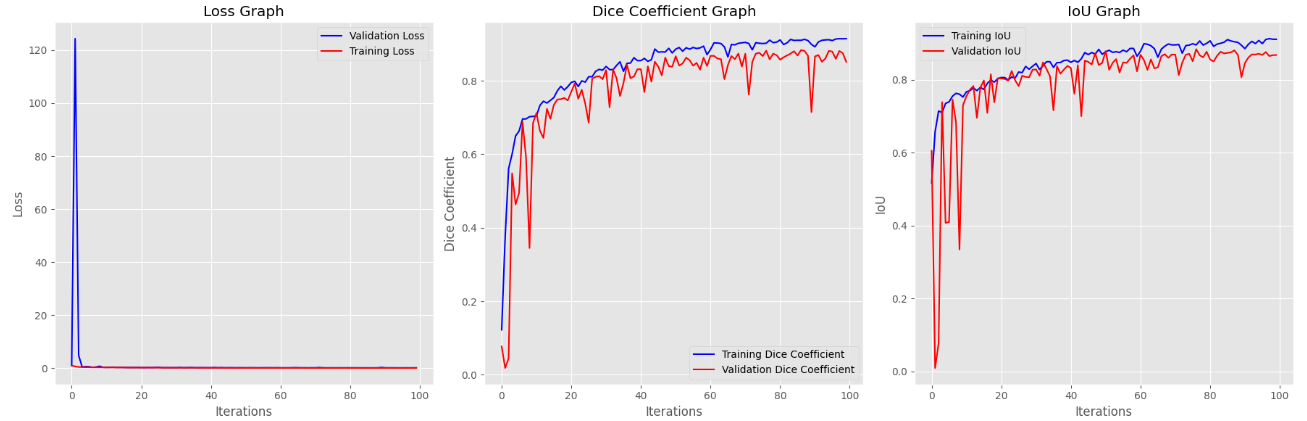

In [65]:
display(Image(filename='iou_training_curves.png'))

In [31]:
model = load_model('unet_brain_mri_seg1.keras', custom_objects={
    'dice_coefficients': dice_coefficients,
    'dice_coefficients_loss': dice_coefficients_loss,
    'combined_loss': combined_loss,
    'iou': iou
})

In [32]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height,im_width))

results = model.evaluate(test_gen, steps = int(len(df_test)/BATCH_SIZE))
print('Test Loss', results[0])
print('Test IOU', results[2])
print('Test Dice Coeff', results[3])

Found 786 validated image filenames.
Found 786 validated image filenames.
24/24 ━━━━━━━━━━━━━━━━━━━━ 167s 7s/step - binary_accuracy: 0.9982 - dice_coefficients: 0.9069 - iou: 0.8981 - loss: 0.1026
Test Loss 0.10546547174453735
Test IOU 0.8909031748771667
Test Dice Coeff 0.9049405455589294


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


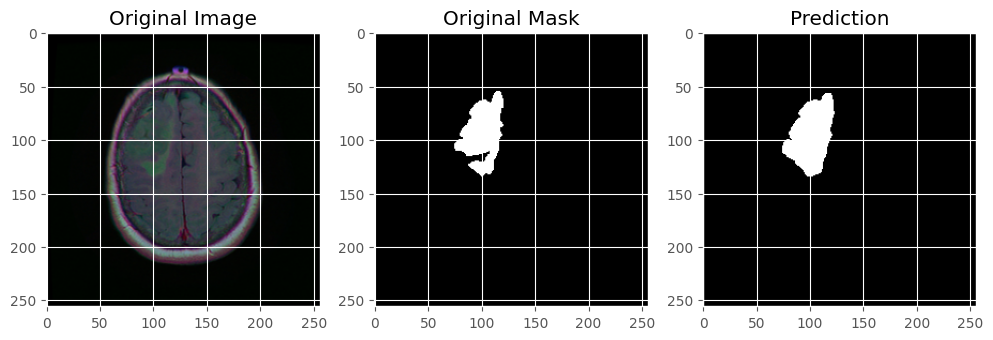

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


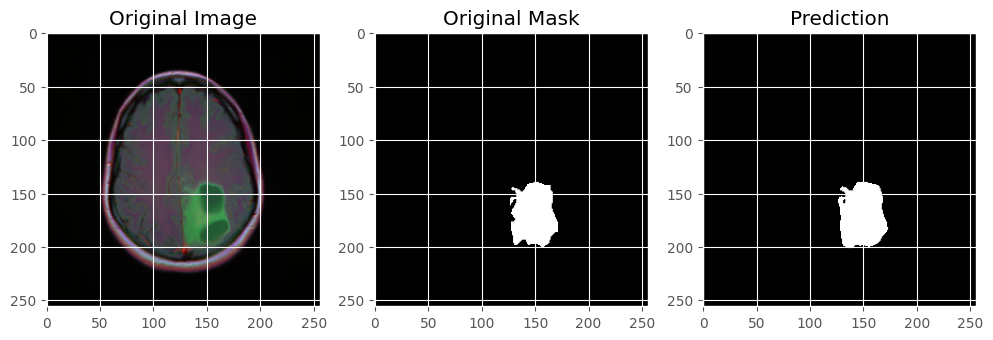

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


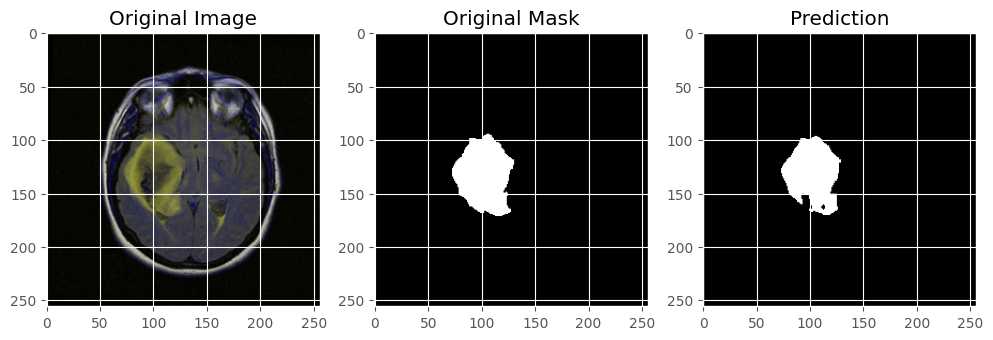

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


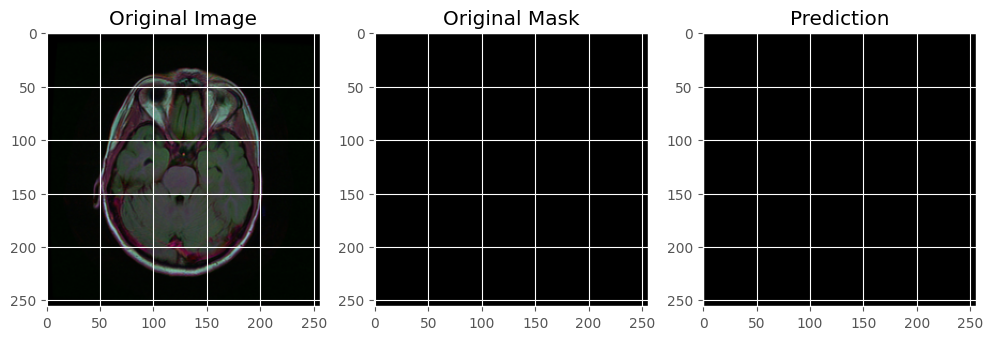

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


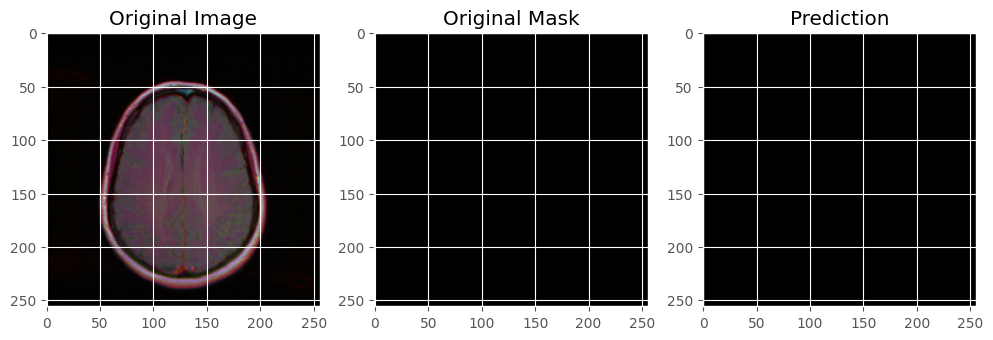

In [34]:
for i in range(5):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filename_train'].iloc[index])
    img = cv2.resize(img, (im_height,im_width))
    img = img/255
    img = img[np.newaxis, : ,:, :]
    pred_img = model.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img>0.5), cmap='gray')
    plt.title("Prediction")
    plt.show()

In [43]:
@tf.keras.utils.register_keras_serializable()    
class ResizeLayer(Layer):
    def __init__(self, target_size, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_size = target_size

    def call(self, inputs):
        return tf.image.resize(inputs, self.target_size)
    
    def get_config(self):
        config = super(ResizeLayer, self).get_config()
        config.update({"target_size": self.target_size})
        return config

def mish(x):
    return x * K.tanh(K.softplus(x))

def residual_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation(mish)(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(mish)(x)

    shortcut = Conv2D(num_filters, (1, 1), padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    
    
    return x

def mag_attention_gate(x, g, inter_shape):
    # Downsample x
    theta_x = Conv2D(inter_shape, (1, 1), strides=(2, 2), padding='same')(x)
    theta_x = BatchNormalization()(theta_x)
  

    # Process gating signal g
    phi_g = Conv2D(inter_shape, (1, 1), strides=(1, 1), padding='same')(g)
    phi_g = BatchNormalization()(phi_g)

    # Combine x and g
    concat_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(concat_xg)
    psi = BatchNormalization()(act_xg)
    
    # Calculate attention weights
    psi = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(act_xg)
    alpha = Activation('sigmoid')(psi)
    
    x_shape = K.int_shape(x)

# Extract the height and width dimensions
    height, width = x_shape[1], x_shape[2]

# Use the height and width to define the target size
    target_size = (height, width)
    
    

# Assuming x is a Keras tensor and target_size is defined
# Create an instance of the ResizeLayer
    resize_layer = ResizeLayer(target_size)
    upsampled_alpha = resize_layer(x)
    x = Multiply()([x, upsampled_alpha])

 

 


    return x

In [44]:
def magres_unet(input_size=(256, 256, 3), num_classes=1):
    inputs = Input(input_size)

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = residual_block(p4, 1024)

    # Decoder
    a4 = mag_attention_gate(c4, bn, 512)
    d4 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn)
    d4 = concatenate([d4, a4])
    d4 = residual_block(d4, 512)
    
    a3 = mag_attention_gate(c3, d4, 256)
    d3 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(d4)
    d3 = concatenate([d3, a3])
    d3 = residual_block(d3, 256)
    
    a2 = mag_attention_gate(c2, d3, 128)
    d2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d3)
    d2 = concatenate([d2, a2])
    d2 = residual_block(d2, 128)
    
    a1 = mag_attention_gate(c1, d2, 64)
    d1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    d1 = concatenate([d1, a1])
    d1 = residual_block(d1, 64)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(d1)

    model = Model(inputs, outputs)
    return model

In [45]:
model3 = magres_unet(input_size=(im_height, im_width, 3), num_classes=1)
model3.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_54       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_54[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_58[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 256, 256,  │        256 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ activation_55[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_56[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 128, 128,  │      8,320 │ max_pooling2d_12

 Total params: 32,462,849 (123.84 MB)

 Trainable params: 32,445,185 (123.77 MB)

 Non-trainable params: 17,664 (69.00 KB)

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model3.compile(optimizer=adam_optimizer, loss=combined_loss,  metrics=["accuracy", iou, dice_coefficients])
checkpoint = ModelCheckpoint('unet_brain_mri_seg3.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

history = model3.fit(train_gen, steps_per_epoch=int(len(df_train) / BATCH_SIZE), epochs=100, validation_data=test_gener, callbacks=[checkpoint, early_stopping, reduce_lr], validation_steps=int(len(df_val) / BATCH_SIZE))

In [46]:
model3 = load_model('unet_brain_mri_seg3.keras', custom_objects={
    'dice_coefficients': dice_coefficients,
    'dice_coefficients_loss': dice_coefficients_loss,
    'combined_loss': combined_loss,
    'iou': iou,
    'ResizeLayer': ResizeLayer
    
})


In [47]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height,im_width))

results = model3.evaluate(test_gen, steps = int(len(df_test)/BATCH_SIZE))
print('Test Loss', results[0])
print('Test IOU', results[2])
print('Test Dice Coeff', results[3])

Found 786 validated image filenames.
Found 786 validated image filenames.
24/24 ━━━━━━━━━━━━━━━━━━━━ 205s 8s/step - accuracy: 0.9984 - dice_coefficients: 0.9194 - iou: 0.9129 - loss: 0.0883
Test Loss 0.08796581625938416
Test IOU 0.911514937877655
Test Dice Coeff 0.9201915860176086


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


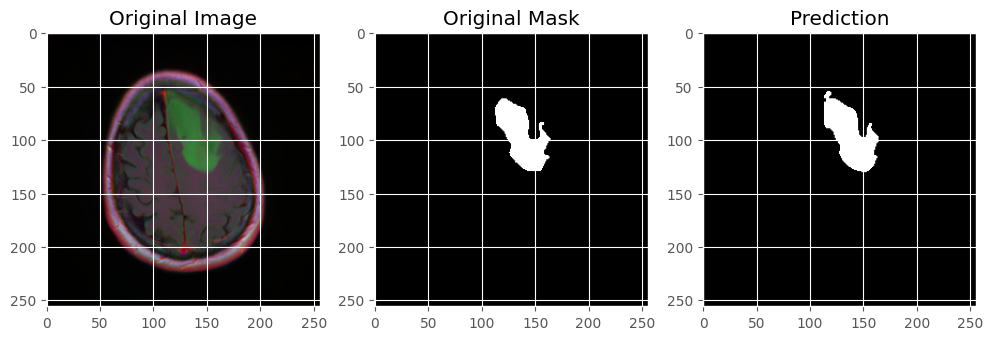

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


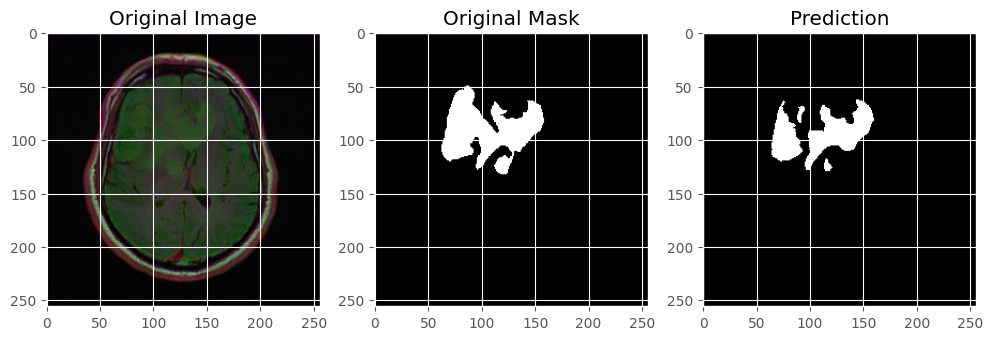

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


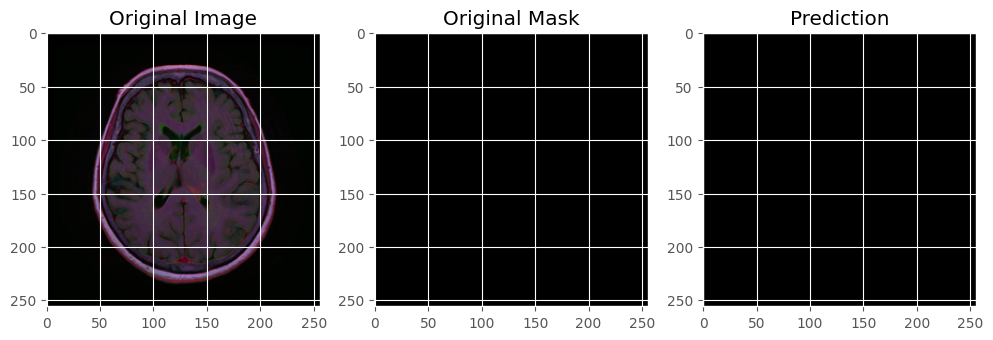

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


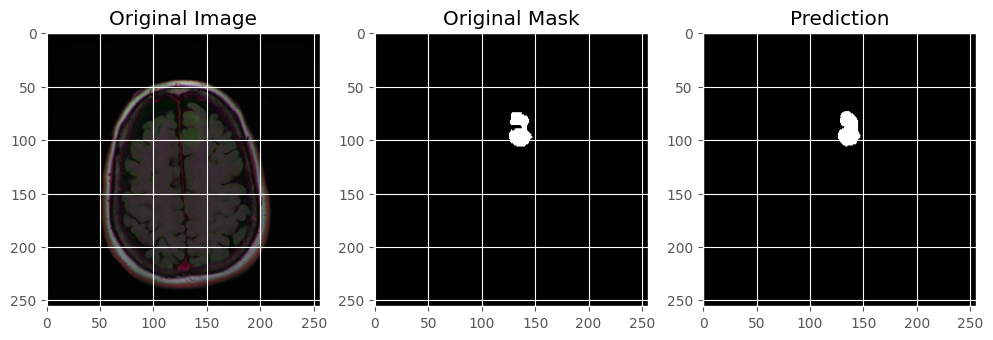

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


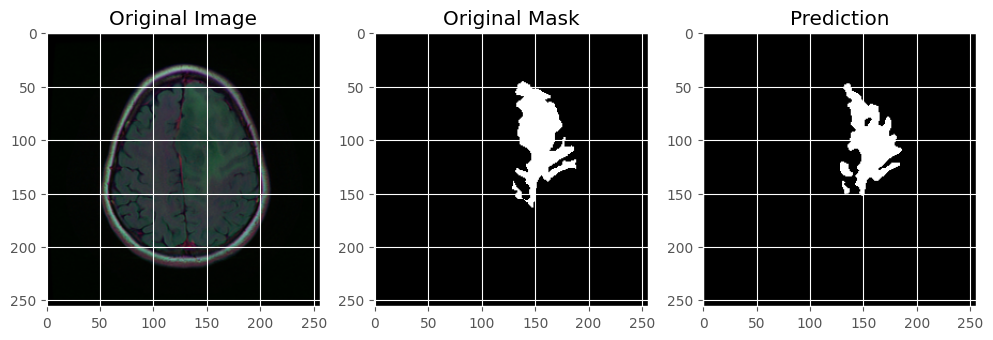

In [74]:
for i in range(5):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filename_train'].iloc[index])
    img = cv2.resize(img, (im_height,im_width))
    img = img/255
    img = img[np.newaxis, : ,:, :]
    pred_img = model3.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img>0.5), cmap='gray')
    plt.title("Prediction")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


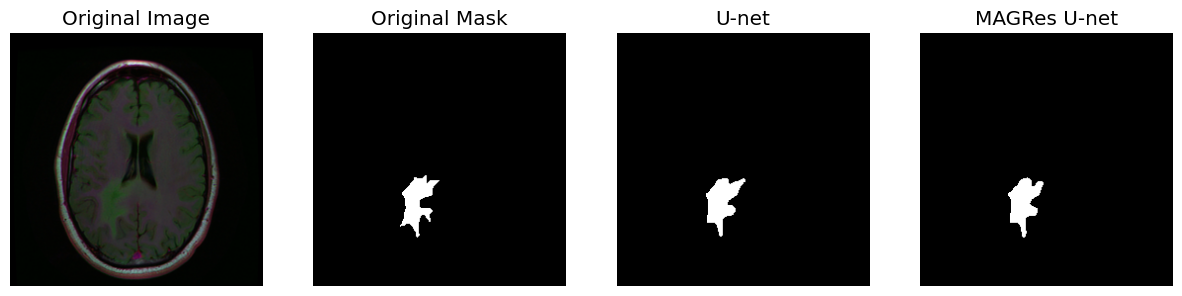

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


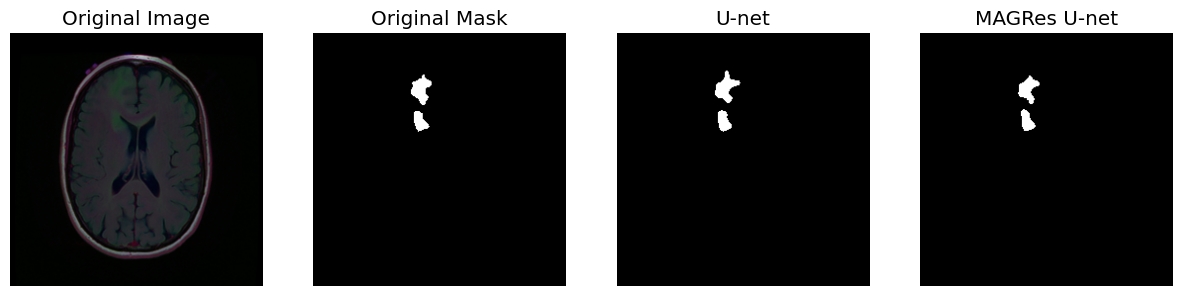

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


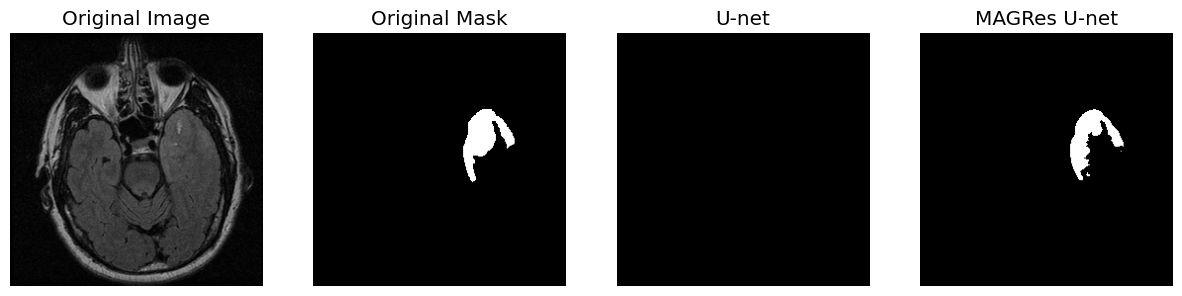

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


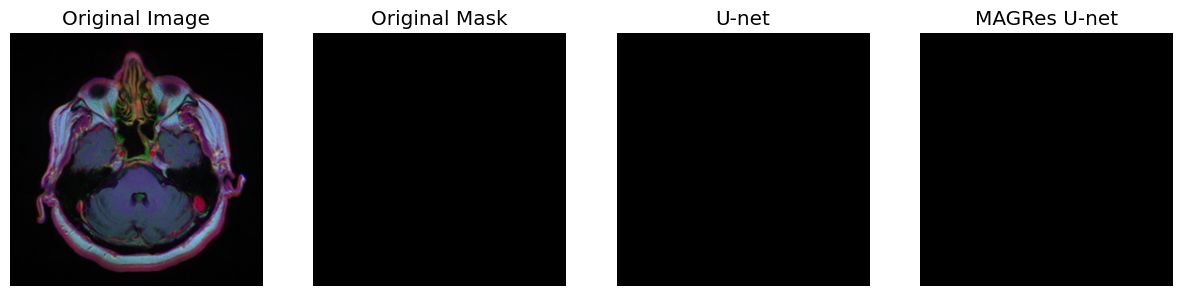

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


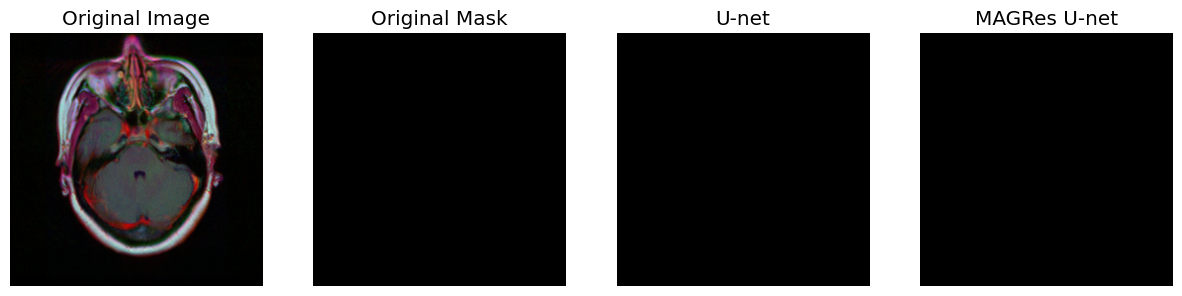

In [64]:

for i in range(5):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filename_train'].iloc[index])
    img = cv2.resize(img, (im_height,im_width))
    img = img/255
    img = img[np.newaxis, : ,:, :]
    pred_img1 = model.predict(img)
    pred_img3 = model3.predict(img)
    
    plt.figure(figsize=(15,10))
    plt.subplot(1, 4, 1)
    plt.imshow(np.squeeze(img))
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title("Original Mask")
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(np.squeeze(pred_img1>0.5), cmap='gray')
    plt.title("U-net")
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(np.squeeze(pred_img3>0.5), cmap='gray')
    plt.title("MAGRes U-net")
    plt.axis('off')
    plt.show()
